In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv
/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


This notebook is created for the Playground Series 3- Episode 12. It uses the original and the synthetic dataset created from the same source
https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis.

| Column name | Explanation |
| --- | --- |
specific gravity |  Density of urine contrast to water
pH | How acidic/basic the urine is
osmolarity | Molecule concentration
conductivity | Concentration of charged ions in the sample
urea concentration | Concentration of urea in milimoles/litre
calcium concentration | Concentration of calcium in milimoles/litre
target | Classification Label

I achieved 0.87600 as area under ROC Curve score, and became the top 12% in the competition with this notebook.

In [2]:
import xgboost as xgb
import lightgbm as lgb
import optuna

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve


In [3]:
train_ds = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
test_ds = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
orig_train_ds = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')

train_ds.drop('id', axis = 1, inplace = True)
test_ds.drop('id', axis = 1, inplace=True)

training = pd.concat([train_ds, orig_train_ds])

X = training.drop(columns = ['target'],  axis =1)
y = training['target']

# EDA

In [4]:
def show_stats(dataset):
    d_dsc = dataset.describe().T
    d_dsc['unique'] = dataset.nunique()
    d_dsc['unique_perc%'] = d_dsc['unique'] / len(dataset) * 100
    d_dsc['null'] = dataset.isna().sum()
    d_dsc["duplicated"] = dataset.duplicated().sum()
    d_dsc['type'] = dataset.dtypes 
    return d_dsc

In [5]:
print("Stats of the Synthetic Training Dataset")
show_stats(train_ds)

Stats of the Synthetic Training Dataset


,count,mean,std,min,25%,50%,75%,max,unique,unique_perc%,null,duplicated,type
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04,28,6.763285,0,0,float64
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94,71,17.149758,0,0,float64
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00,80,19.323671,0,0,int64
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00,65,15.700483,0,0,float64
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00,73,17.632850,0,0,int64
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34,85,20.531401,0,0,float64
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00,2,0.483092,0,0,int64


In [6]:
print("Stats of the Original Dataset")
show_stats(orig_train_ds)

Stats of the Original Dataset


,count,mean,std,min,25%,50%,75%,max,unique,unique_perc%,null,duplicated,type
id,414.0,206.500000,119.655756,0.000,103.250,206.500,309.750,413.00,414,100.000000,0,0,int64
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04,28,6.763285,0,0,float64
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94,71,17.149758,0,0,float64
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00,80,19.323671,0,0,int64
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00,65,15.700483,0,0,float64
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00,73,17.632850,0,0,int64
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34,85,20.531401,0,0,float64
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00,2,0.483092,0,0,int64


In [7]:
print("Stats of the Test Dataset")
show_stats(test_ds)

Stats of the Test Dataset


,count,mean,std,min,25%,50%,75%,max,unique,unique_perc%,null,duplicated,type
gravity,276.0,1.018330,0.006569,1.005,1.0140,1.019,1.02325,1.034,27,9.782609,0,0,float64
ph,276.0,5.939312,0.607143,4.900,5.5300,5.730,6.21000,7.940,62,22.463768,0,0,float64
osmo,276.0,654.891304,236.361932,187.000,456.0000,658.000,843.25000,1236.000,75,27.173913,0,0,int64
cond,276.0,21.886594,7.346069,5.100,17.4000,23.600,27.60000,38.000,58,21.014493,0,0,float64
urea,276.0,280.985507,134.877856,64.000,168.5000,282.000,385.00000,620.000,71,25.724638,0,0,int64
calc,276.0,4.076848,3.088524,0.170,1.5275,3.230,5.54000,14.340,74,26.811594,0,0,float64


We can see that synthetic, original and test datasets, do not contain null or duplicated values. Both of the datasets have numerical columns. As far as we can see all columns have similar distributions over different datasets. And gravitiy column appears to have very few unique values.

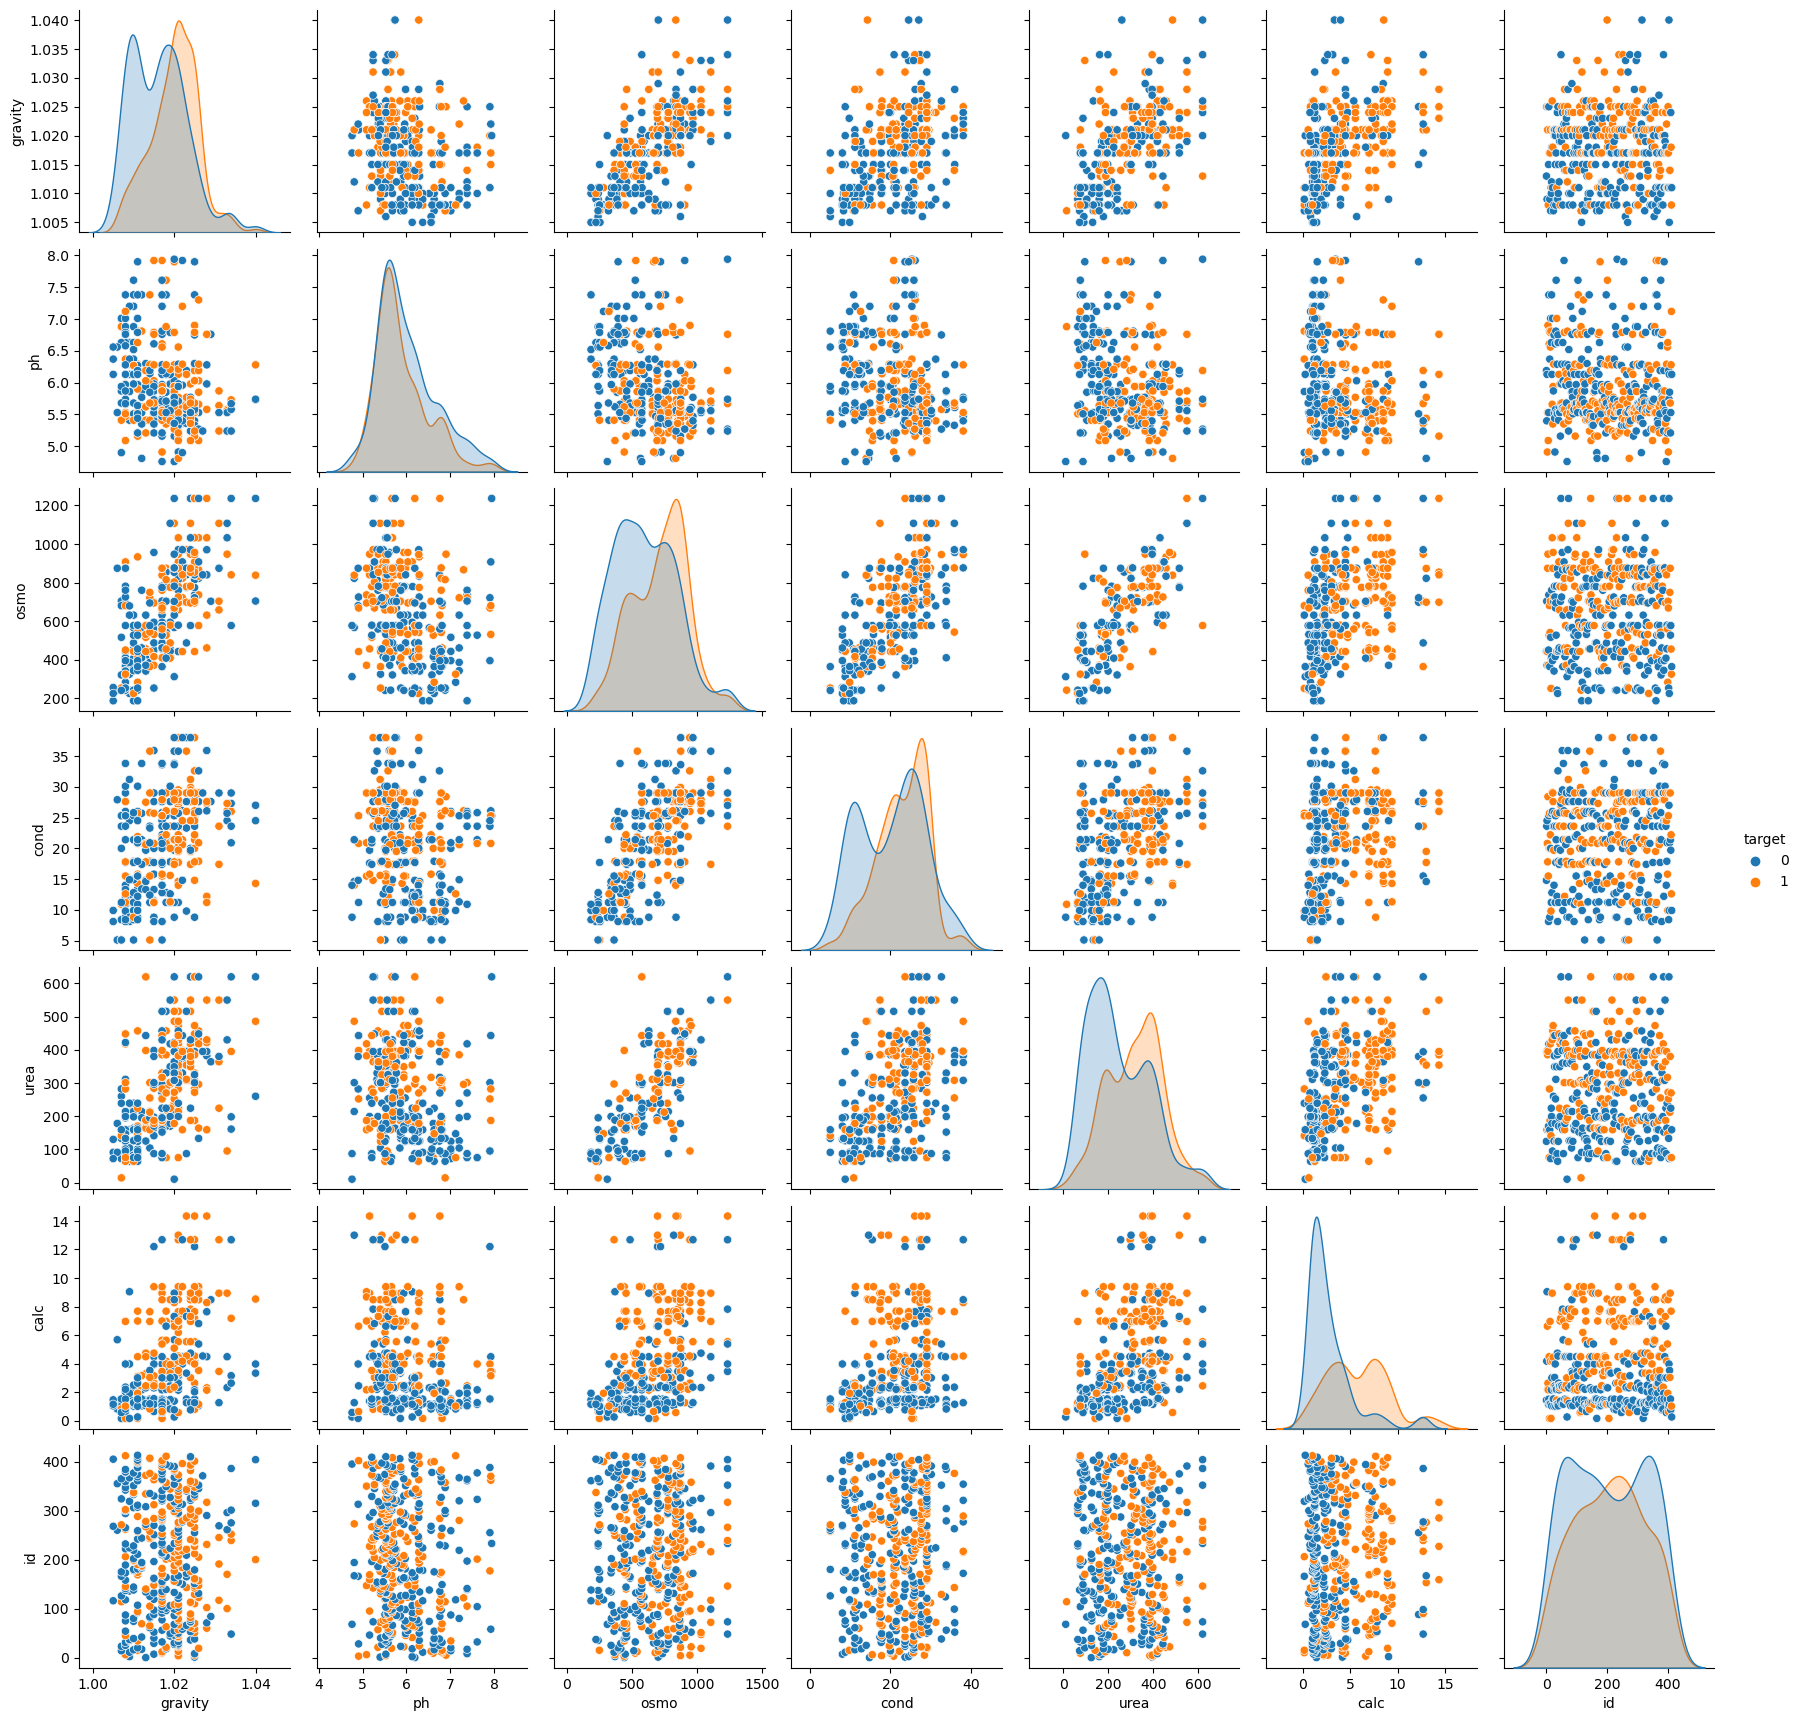

In [8]:
sns.pairplot(training, hue="target")

1. Calc separates target the most given the density functions, it could be the most important feature to predict presecne of kidney stones.
2. Osmo and gravity seem to have high positive correlation
3. Ph feature seem to have not much use to predict the presence of the stones, as prob. density func. seems too similar for both cases.

<AxesSubplot:>

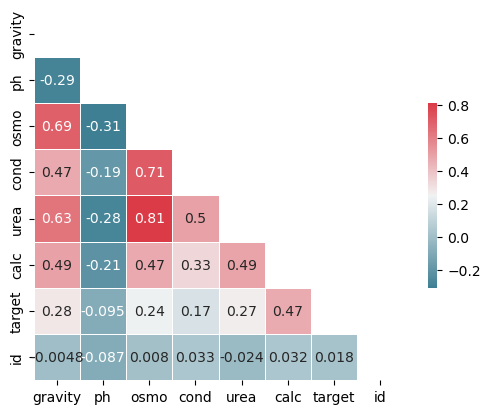

In [9]:
corr = training.corr('pearson')
sns.heatmap(corr, mask=np.triu(np.ones_like(corr)), cmap=sns.diverging_palette(220, 10, as_cmap=True), annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


From the graph above, 
1. There is a high positive correlation between "osmo" and "urea" columns.
2. There is a moderate-high positive correlation between "osmo" and "cond" columns.
3. There is a moderate positive corelation between "urea" and "cond", also with "urea" and "calc" columns.
4. There is a moderate positive corelation between "urea" and "gravity" columns.
5. There is a moderate positive corelation between "calc" and "gravity" columns.

In [10]:
def plot_distributions(data, columns, title):
    fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi = 100)
    ax = ax.flatten()
    for i, column in enumerate(columns):
        sns.kdeplot(data[column], ax=ax[i])    
        ax[i].set_title(f'{column} Distributions')
        ax[i].set_xlabel(None)

    fig.suptitle(title, fontsize = 24, fontweight = 'bold')

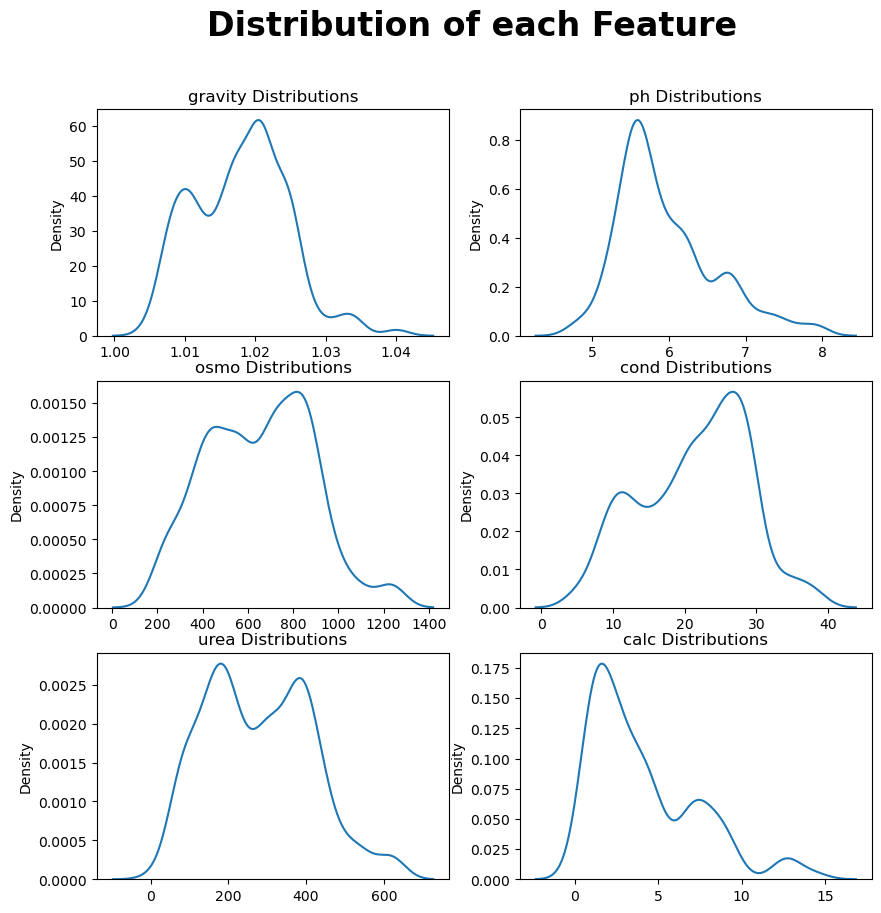

In [11]:
plot_distributions(training, ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], 'Distribution of each Feature')

1. Distributions of "urea", "osmo",  in the above graph seems bimodal. We may need to transform them to the normal distribution before training.
2. Distributions of "gravity" and "cond" looks so similar.
3. Distributions of "ph" and "calc" looks so similar.
4. There may be some outliers in "calc" feature.

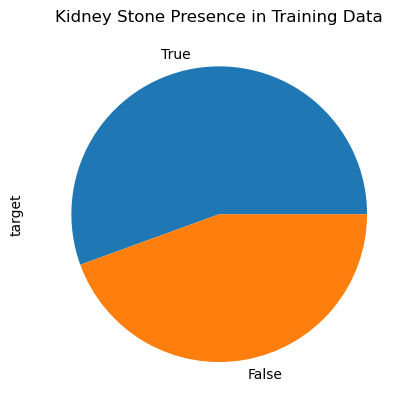

In [12]:
labels = "True", "False"
ax = y.value_counts().plot.pie(y='target', title= 'Kidney Stone Presence in Training Data', labels=labels)

# PREPROCESSING

In [13]:
columns = ['calc']
for col in columns:
    q_low = training[col].quantile(0.1)
    q_hi  = training[col].quantile(0.9)

cleaned_df = training[(training[col] < q_hi) & (training[col] > q_low)]

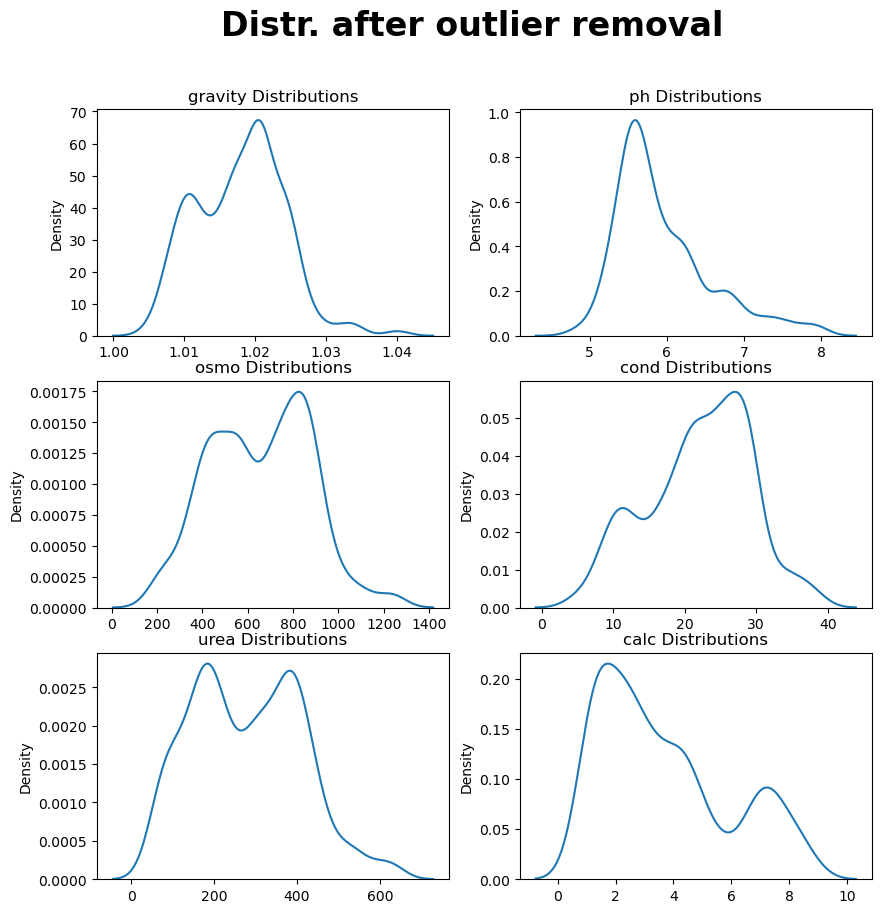

In [14]:
plot_distributions(cleaned_df, ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], 'Distr. after outlier removal')

After removing the outliers, all of the distributions look slightly better as they are getting closer to a normal distribution.

In [15]:
from sklearn.preprocessing import QuantileTransformer, RobustScaler, PowerTransformer

transformed_training = pd.DataFrame()
qt_columns = ['urea', 'osmo', 'gravity', 'calc' ]
pt_columns = ['ph', 'cond']

for i, column in enumerate(pt_columns):
    pt = PowerTransformer(method="yeo-johnson").fit_transform(cleaned_df[column].values.reshape(-1, 1))
    transformed_training[column] = pd.DataFrame(pt)
for i, column in enumerate(qt_columns):
    tf = QuantileTransformer().fit_transform(X=cleaned_df[column].values.reshape(-1, 1))
    transformed_training[column] = pd.DataFrame(tf)
    
for i, column in enumerate(pt_columns):
    pt = RobustScaler().fit_transform(cleaned_df[column].values.reshape(-1, 1))
    transformed_training[column] = pd.DataFrame(pt)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (660). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (660). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (660). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (660). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


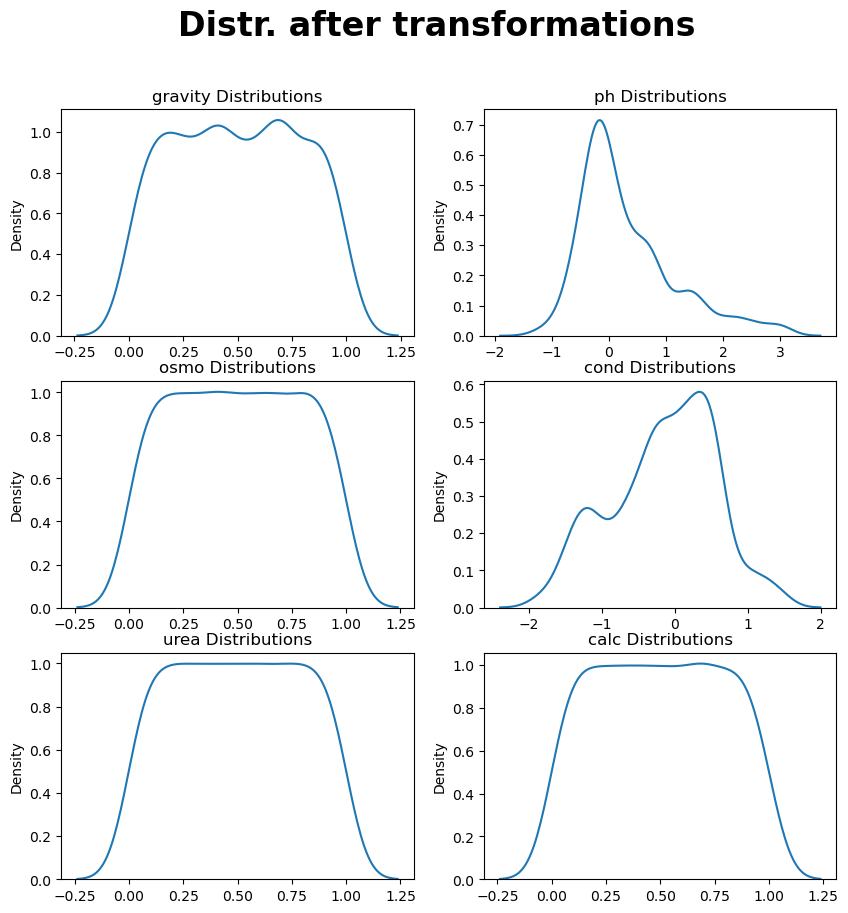

In [16]:
plot_distributions(transformed_training, ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], 'Distr. after transformations')

In [17]:
X = transformed_training
y = cleaned_df['target']

# TRAINING

In [18]:
def plot_eval_metrics(train_m, val_m, metric, title):
    plt.plot(train_m, label='train')
    plt.plot(val_m, label='validation')
    plt.ylabel(metric)
    plt.xlabel('Boosting round')
    plt.title(title)
    plt.legend()
    plt.show()

### LGBM H.PARAM TUNING

In [19]:
# import optuna.integration.lightgbm as lgb
# from lightgbm import early_stopping
# from lightgbm import log_evaluation
# from sklearn.metrics import accuracy_score

# optuna.logging.disable_default_handler()

# def train(trial):
#     param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'learning_rate'   :trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'verbose': -1,
#         'feature_pre_filter' : False
#     }

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)): 
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
#         dtrain = lgb.Dataset(X_train, label=y_train)
#         dval = lgb.Dataset(X_val, label=y_val)
#         lgb_model = lgb.train(param, dtrain, valid_sets=[dtrain, dval], verbose_eval=False,
#                     callbacks=[early_stopping(100), log_evaluation(100)])
#         preds = np.rint(lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration))
#         accuracy = accuracy_score(y_val, preds)
#         return accuracy



# study_lgbm = optuna.create_study(direction="maximize")
# study_lgbm.optimize(train, n_trials=50)

In [20]:
study_lgbm = {
    'best_params': {
        'lambda_l1': 7.444940822812977e-08,
        'lambda_l2': 1.5274601770345386,
        'num_leaves': 250,
        'feature_fraction': 0.4129928590439077,
        'bagging_fraction': 0.7062818831860239,
        'bagging_freq': 3,
        'min_child_samples': 89,
    }
}

### TRAIN LGBM

In [21]:
import lightgbm as l_lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.metrics import accuracy_score

param = {
        'objective': 'binary',
        'metric': ["auc", 'binary_logloss'],
        **study_lgbm['best_params']
    }
evals_result = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)): 
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    dtrain = l_lgb.Dataset(X_train, label=y_train)
    dval = l_lgb.Dataset(X_val, label=y_val)
    lgb_model = l_lgb.train(param, dtrain, valid_sets=[dtrain, dval], evals_result=evals_result, valid_names = ['validation', 'train'],
                callbacks=[early_stopping(100), log_evaluation(100)])

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 224, number of negative: 304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 528, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424242 -> initscore=-0.305382
[LightGBM] [Info] Start training from score -0.305382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

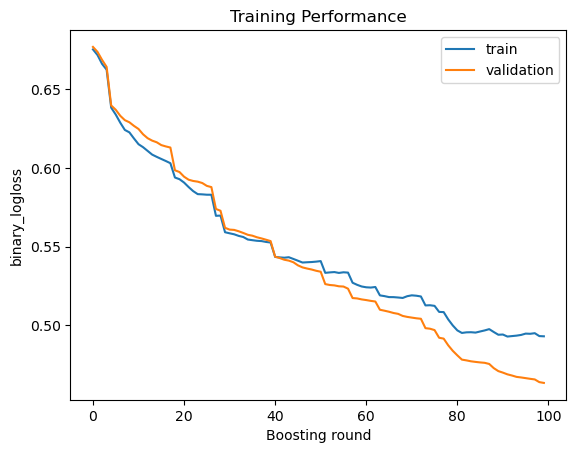

In [22]:
plot_eval_metrics(evals_result['train']['binary_logloss'], evals_result['validation']['binary_logloss'], 'binary_logloss', 'Training Performance')

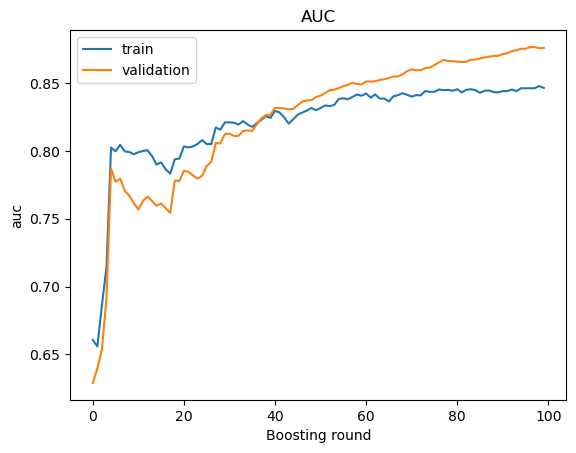

In [23]:
plot_eval_metrics(evals_result['train']['auc'], evals_result['validation']['auc'], 'auc', 'AUC')

### XGB H.PARAMS TUNING

In [24]:
# import xgboost as xgb

# def train(trial):
#     param = {
#         'objective': 'binary:logistic',
#         'eval_metric': ["auc", 'logloss'],
#         'eta': trial.suggest_float('eta', 0.01, 0.3),
#         'tree_method': "hist", 
#         'max_depth': trial.suggest_int('max_depth', 6, 15),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),          
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
#         'learning_rate'   :trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
#         'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
#         'lambda': trial.suggest_float('lambda', 1e-8, 1.0),   
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_samples', 1, 10),
#         'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10),
#         'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),
#         'min_split_loss': trial.suggest_float('min_split_loss', 1e-8, 1.0)
#     }

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)): 
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
#         x_tr = xgb.DMatrix(X_train, y_train)
#         x_eval = xgb.DMatrix(X_val, y_val)
#         evals = [(x_tr, "train"), (x_eval, "validation")]
#         xgb_model = xgb.train(params=param, dtrain=x_tr, evals = evals, verbose_eval = 0, num_boost_round=1000, early_stopping_rounds= 10)

#         preds = np.rint(xgb_model.predict(x_eval))
#         accuracy = accuracy_score(y_val, preds)
#         return accuracy

# study_xgb = optuna.create_study(direction="maximize")
# study_xgb.optimize(train, n_trials=100)

In [25]:
study_xgb = {
    'best_params': {
        'eta': 0.1235172503576541,
        'max_depth': 11,
        'subsample': 0.4326739886890928,
        'colsample_bytree': 0.9195802174469211,
        'grow_policy': 'lossguide',
        'learning_rate': 0.0036815150618710974,
        'alpha': 0.5131969241037851,
        'lambda': 0.049710604023600724,
        'gamma': 0.016091257152274663,
        'min_child_samples': 3,
        'max_delta_step': 4,
        'scale_pos_weight': 1.3669766284368359,
        'tree_method': 'approx',
        'min_split_loss': 0.2612907311709575
    }
}

### TRAINING XGB CLASSIFIER

In [26]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': ["auc", 'logloss'],
    **study_xgb['best_params']
    }
eval_results={}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)): 
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_tr = xgb.DMatrix(X_train, y_train)
    x_eval = xgb.DMatrix(X_val, y_val)
    evals = [(x_tr, "train"), (x_eval, "validation")]
    xgb_model = xgb.train(params=xgb_params, dtrain=x_tr, evals = evals, evals_result=eval_results, verbose_eval = 0, num_boost_round=1000, early_stopping_rounds= 10)

[06:33:03] WARNING: ../src/learner.cc:627: 
Parameters: { "min_child_samples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:33:10] WARNING: ../src/learner.cc:627: 
Parameters: { "min_child_samples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:33:17] WARNING: ../src/learner.cc:627: 
Parameters: { "min_child_samples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter act

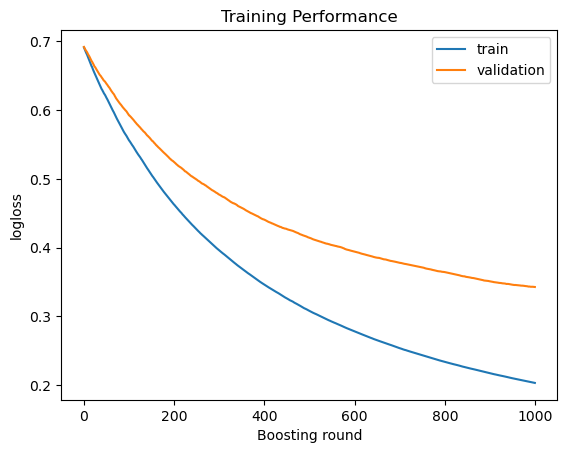

In [27]:
plot_eval_metrics(eval_results['train']['logloss'], eval_results['validation']['logloss'], 'logloss', 'Training Performance')

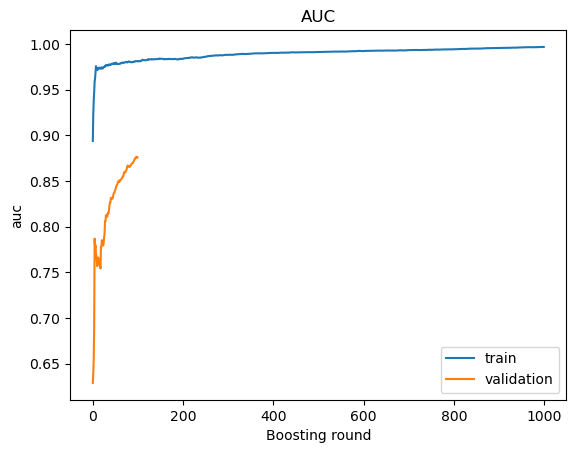

In [28]:
plot_eval_metrics(eval_results['train']['auc'], evals_result['validation']['auc'], 'auc', 'AUC')

In [29]:
import pickle

pickle.dump(xgb_model, open('/kaggle/working/xgb_v1.pickle', "wb"))
pickle.dump(lgb_model, open('/kaggle/working/lgbm_v1.pickle', "wb"))

### FEATURE IMPORTANCE

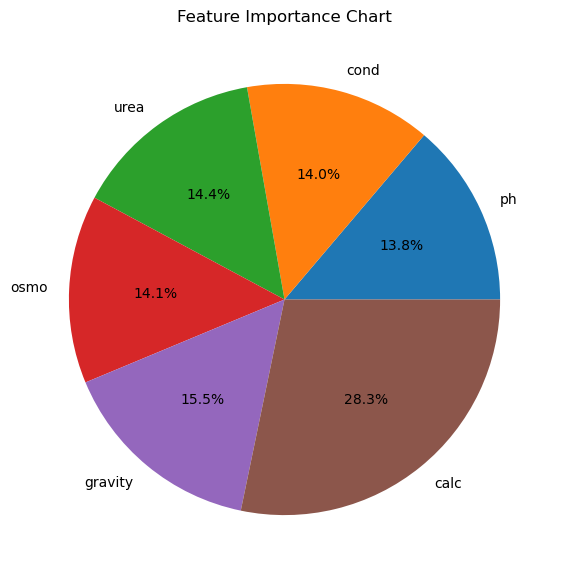

In [30]:
importance = xgb_model.get_score(importance_type= "gain")
features = list(importance.keys())
values = list(importance.values())
fig, ax = plt.subplots(figsize =(10, 7))

ax.set_title("Feature Importance Chart")
plt.pie(values, labels=features, autopct = lambda pct: "{:.1f}%".format(pct))
plt.show()

# SUBMISSION

We should not forget to transform test input same as how we transformed the training data.

In [31]:
transformed_test = pd.DataFrame()

qt_columns = ['urea', 'osmo', 'gravity', 'calc' ]
pt_columns = ['ph', 'cond']

for i, column in enumerate(pt_columns):
    pt = PowerTransformer(method="yeo-johnson").fit_transform(test_ds[column].values.reshape(-1, 1))
    transformed_test[column] = pd.DataFrame(pt)
for i, column in enumerate(qt_columns):
    tf = QuantileTransformer().fit_transform(X=test_ds[column].values.reshape(-1, 1))
    transformed_test[column] = pd.DataFrame(tf)
for i, column in enumerate(pt_columns):
    pt = RobustScaler().fit_transform(test_ds[column].values.reshape(-1, 1))
    transformed_test[column] = pd.DataFrame(pt)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (276). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (276). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (276). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (276). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


In [32]:
transformed_test = transformed_test.reindex(['ph', 'cond', 'urea', 'osmo', 'gravity', 'calc'], axis=1)
test_xgb = xgb.DMatrix(transformed_test)
lgbm_pred = lgb_model.predict(transformed_test)
xgb_pred = xgb_model.predict(test_xgb)

In [33]:
ensembled_prediction = (0.5*xgb_pred)+(0.5*lgbm_pred)

In [34]:
# ids = pd.read_csv("/kaggle/input/playground-series-s3e12/test.csv")['id']
# submission = pd.DataFrame(data={'id': ids, 
#                                 'target': ensembled_prediction})
# submission.to_csv('submission.csv', index=False)